## Using Dask to Scale Your Analysis with a Bit of Deferred Compute

Now that you've learned the basics of managing satellite imagery data and running analysis we want to highlight some of the more sophisticated features of GBDX Notebooks that allow more enfficent analysis of bigger data.  Specifically, we'll highlight the integration of [Dask](https://dask.pydata.org/en/latest/array-overview.html) and deferred compute to GBDX Notebooks, and how you can leverage it for running your analysis on moderatley sized geographies.  Specifically we'll use Dask Array for our computation:

>*Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array >into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these >blocked algorithms using dask graphs.*

The tutorials to date have focused on relatively small AOI's; tens to a hundred square kilometers in size.  Leveraging Dask we'll illustrate how to run an analysis over an entire strip of DigitalGlobe imagery.  A strip of DigitalGlobe data is 360km x 16.4/13.2km for Wordlview-2 (5,904sqkm) and Worldview-3 (4,752sqkm) respectively.  Trying to run an analysis of this size in the notebook pretty much guarantees you'll use all your memory and kill the kernel.  To get around this constraint we'll use Dask to turn our big strip into smaller chunks of data and defer the compute until we need it.  That way we don't have to load the whole strip into memory in order to analyze it.  

This approach works particularily well when we want to test out our analytical methods over a larger sample of data and iterate to find an optimal approach.  Once we have the optimal approach we can use "task deploy" and the GBDX workflow system to scale out our analysis as big as we like.  We'll be adding to the tutorials series to cover more advanced scaling features of GBDX in the near future.  

For now we'll revisit our classic NDVI example from the [beginner band math tutorial](https://notebooks.geobigdata.io/hub/notebooks/5a3ad6989b604e2ff535c27b) and show how we can apply the Dask deferred compute pattern to it. Since we are working with entire strips of imagery we can use the imagery tab to just find a CatalogID that we find interesting.  You can find the CatalogID after you do a search by clicking on "preview" in the search results.  This will also show you the geographic extent of the strip on the map as a low resolution image.  Once you have your CatalogID we can tee it up with the code below.  For this example we've selected a strip that cuts across the Sydney metro area in Australia.

In [1]:
from gbdxtools import CatalogImage

image = CatalogImage('10400100137F4900')
image.shape, image.ntiles

((8, 11922, 12983), 2397)

As expected the image is pretty huge and would easily max out the memory we have in the notebook. Instead we'll use Dask to break up our image using the ["chunk"](https://dask.pydata.org/en/latest/array-creation.html) command, and define a function (NDVI) to run over each of the chunks of data.  Quick refresher from our intro band math tutorial - NDVI normalizes reflectivty between zero and one then create a ratio of the difference between the "near infrared" band and the "red" band divided by the sum of the two.  The result will give us a nice spectral index for identifying vegetation in our Sydney image.

In [2]:
import numpy as np

def ndvi(chunk):
    return np.expand_dims(np.clip((chunk[6,:,:] - chunk[4,:,:]) / (chunk[6,:,:] + chunk[4,:,:]), -1, 1), axis=0)

You'll notice the pattern with Dask is a little different from our first NDVI calculation.  We aren't declaring our band as variables but instead calling them directly.  Band 4 = red and Band 6 = NIR and our "chunk" code will allow the same NDVI function to be run across each segment of data then clips the data to -1 and 1 with the resulting spectral index.  Next, we'll use the ["maps_blocks"](https://dask.pydata.org/en/latest/array-ghost.html) command to process our NDVI function across each chunk of data in our strip of imagery.  The result will be an entire strip of NDVI results for Sydney.

In [17]:
processed = image.map_blocks(ndvi, dtype=image.dtype, chunks=(1,512,512))

To check out our results let's plot a random slection of ten 512x512 pixel windows of the NDVI results over Sydney.  Execute the cell a few times to see an assortment of results.

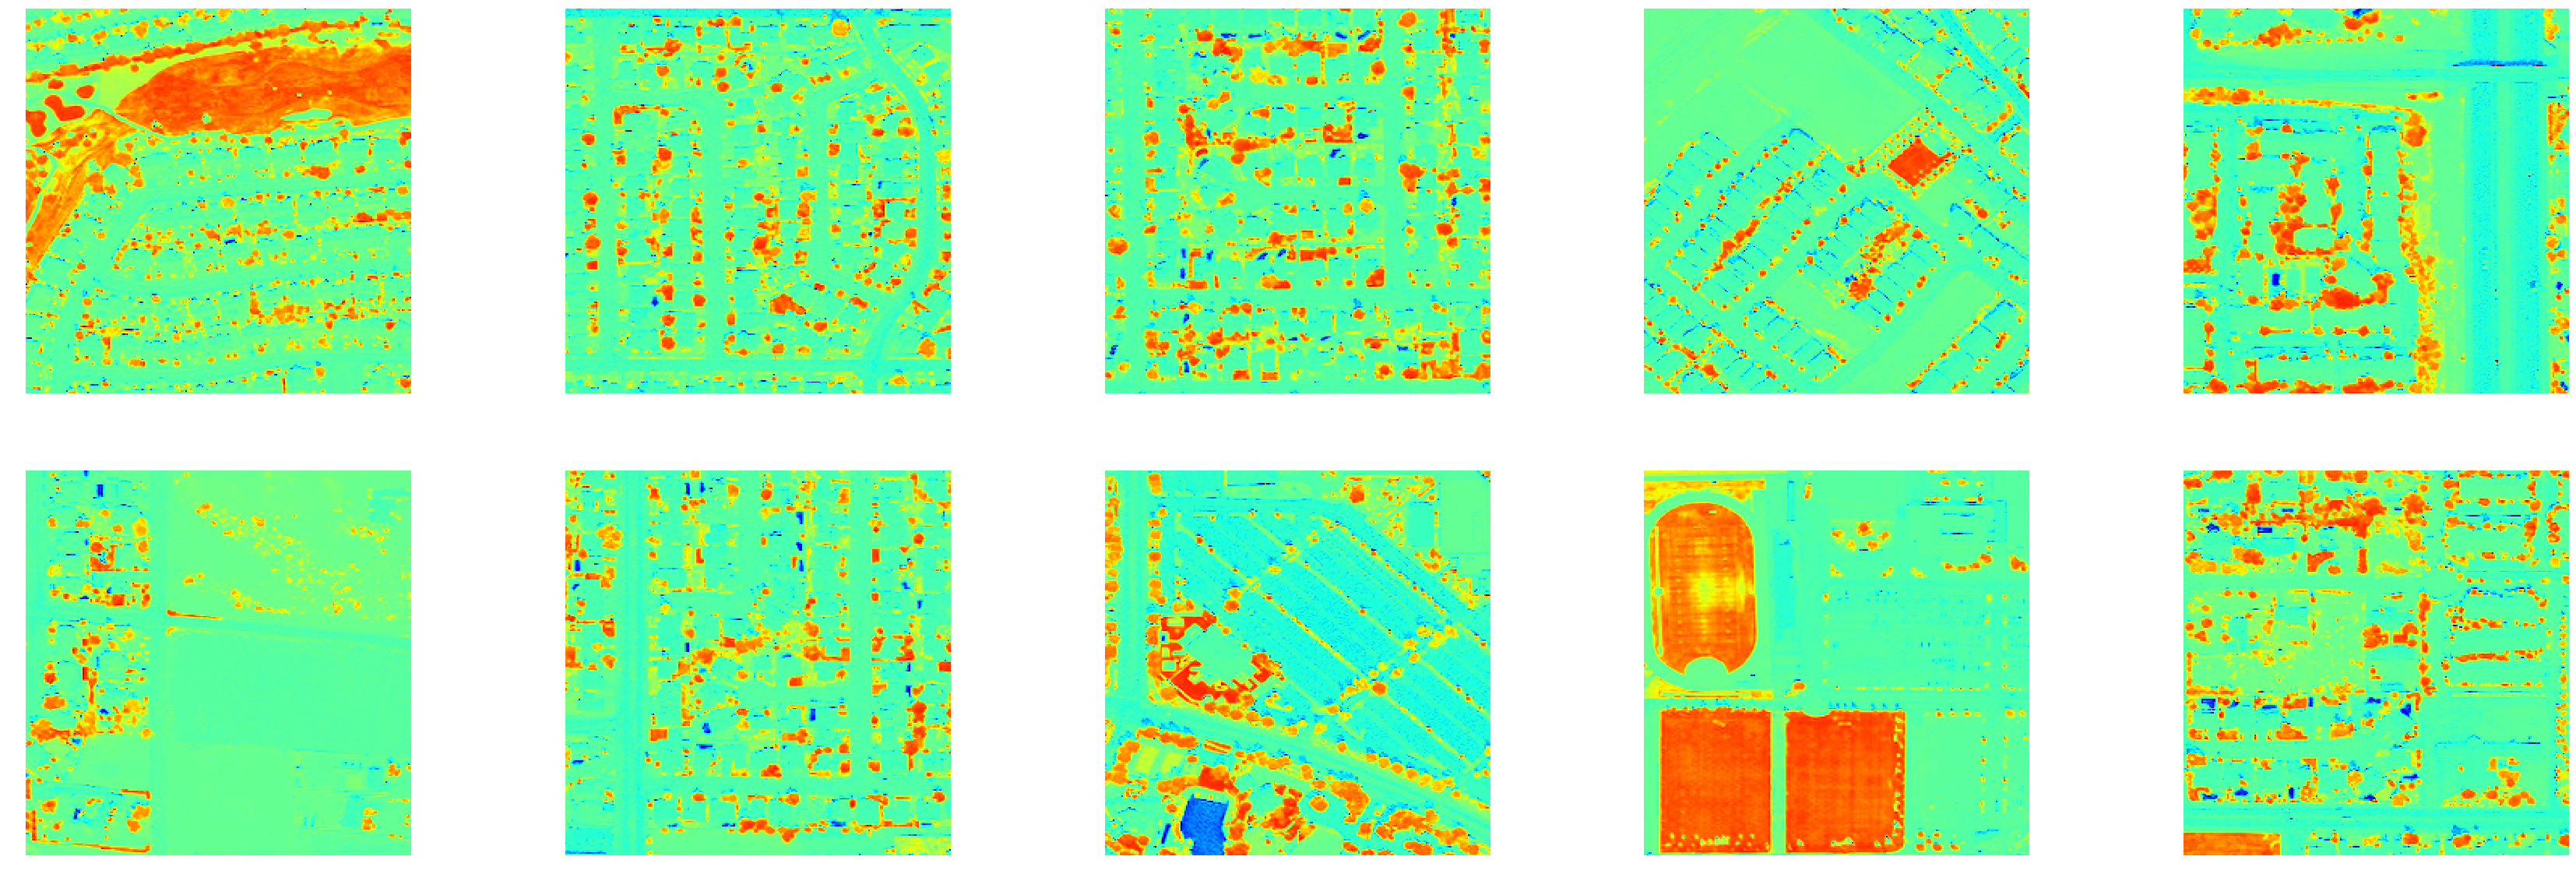

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(60,20))

for i, window in enumerate(processed.iterwindows(10, (512,512))):
    aoi = window.read(quiet=True)
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(aoi[0], cmap="jet")
    
plt.show()

It is fun to see the variety of results as different random blocks of Sydney are analyzed for vegetation intensity.  I particularily like the one of a footie pitch where you can see where the grass has been worn down from lots of use.  We'll follow up this tutorial with a more advanced Dask notebook that shows off some of the more sophisticated techniques and patterns. 